In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

In [2]:
swift = pd.read_csv("./Required Files/Files for Loading/Swift_GRB_catalog.csv") # load full Swift catalog
sGRBs = swift[swift["BAT T90 [sec]"].apply(pd.to_numeric, errors="coerce") <= 2] # filter catalog for GRBs with T90 under 2 sec

In [3]:
mags = pd.Series([]) # numerical magnitudes
lims = pd.Series([]) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

# format columns
sGRBs.drop(['BAT RA (J2000)',
       'BAT Dec (J2000)', 'BAT 90% Error Radius [arcmin]', 'XRT RA (J2000)',
       'XRT Dec (J2000)', 'XRT 90% Error Radius [arcsec]', 'UVOT RA (J2000)',
       'UVOT Dec (J2000)', 'UVOT 90% Error Radius [arcsec]', 'UVOT Magnitude',
       'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # these are redundant--already in master catalog
sGRBs.rename(columns={'BAT Photon Index (15-150 keV) (PL = simple power-law, CPL = cutoff power-law)':'BAT Photon Index (15-150 keV)',
                      'XRT Time to First Observation [sec]':'XRT dt [sec]','UVOT Time to First Observation [sec]':'UVOT dt [sec]',
                      'UVOT Other Filter Magnitudes':'Other UVOT Filters'},inplace=True)

In [4]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = entry.split("|")
    filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
    filterdict["idx"] = idx
    optical_obs.append(filterdict)

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs

In [5]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [6]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,Time [UT],Trigger Number,BAT T90 [sec],BAT Fluence (15-150 keV) [10^-7 erg/cm^2],BAT Fluence 90% Error (15-150 keV) [10^-7 erg/cm^2],BAT 1-sec Peak Photon Flux (15-150 keV) [ph/cm^2/sec],BAT 1-sec Peak Photon Flux 90% Error (15-150 keV) [ph/cm^2/sec],BAT Photon Index (15-150 keV),BAT Photon Index 90% Error (15-150 keV),...,XRT 24 Hour Flux (0.3-10 keV) [10^-11 erg/cm^2/s],XRT Initial Temporal Index,XRT Spectral Index (Gamma),XRT Column Density (NH) [10^21 cm^-2],UVOT dt [sec],Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
14,200522A,11:41:34,973628,0.62,1.1,0.1,1.5,0.2,"1.45, PL",0.17,...,0.0165921492,-0.6754,1.38048,0.445814,448,"{'White': '19.5', 'idx': 14}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
23,200411A,04:29:02,965784,0.22,0.86,0.11,1.1,0.2,"0.95, PL",0.19,...,0.00544167,-0.9587,1.76864,1.473358,58,"{'B': '20.3', 'U': '21.0', 'UVW1': '18.8', 'UV...",Fermi (GBM),NaN,18.5,brightest
61,191031D,21:23:31,932608,0.29,4.1,0.4,4.3,0.4,"0.80, PL",0.15,...,0.0000087841468,-1.982,1.88342,0.657023,93,"{'B': '20.4', 'U': '20.3', 'UVW1': '19.8', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest
91,190627A,11:18:31,911609,1.60,0.99,0.22,1.1,0.3,"2.38, PL",0.38,...,0.36224076,-0.3297,1.95997,1.807500,115,"{'White': '18.15', 'idx': 91}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
95,190610A,11:27:45,907754,0.62,4.1,0.5,3.9,0.5,"0.32, PL",0.27,...,NaN,NaN,NaN,NaN,292282,{'idx': 95},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.3,brightest


In [7]:
obj = sGRBs.loc[14,:]
test_instance = calc_code.GRB(obj["GRB"],obj["XRT dt [sec]"],np.nan,obj["XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]"],0)

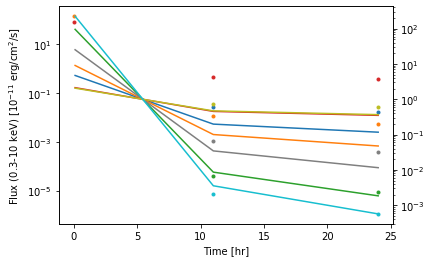

In [8]:
fig, ax1 = plt.subplots() # fig and axis for the datapoint plot
ax2 = ax1.twinx() # axis for the temporal index plot
for i in sGRBs.index[:10]: # only the first 10 points for visibility's sake
    ax1.plot([0,11,24],sGRBs.loc[i,['XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]', 'XRT 11 Hour Flux (0.3-10 keV) [10^-11 erg/cm^2/s]',
    'XRT 24 Hour Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']].apply(pd.to_numeric, errors="coerce"), ".") # plot x-ray flux at 0, 11, and 24 hours
    ax2.plot([.1,11,24],np.power([.1,11,24],pd.to_numeric(sGRBs.loc[i,'XRT Initial Temporal Index'],errors="coerce"))) # plot corresponding "light curve" based on temporal index
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Flux (0.3-10 keV) [$10^{-11}$ erg/cm$^2$/s]")
fig.show()